# Prediction of tumor immune cell infiltration based on extracellular matrix organization

In [1]:
%matplotlib inline
# Import modules
#
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

# Local modules
import auxiliary
import plots
import ExtractMap

## Lecture du jeu de données

On s'intéresse ici différents descripteurs qui sont extraits à partir de différentes positions au sein d'images de coupe histologique de tumeurs.

In [2]:
# Path to dataframes
filepath_wt = "../data/WTconcatenate.csv.gz"
filepath_ki = "../data/KIconcatenate.csv.gz"

# Rea
df_wt = auxiliary.read_dataframe(filepath_wt, low_memory=False)
df_ki = auxiliary.read_dataframe(filepath_ki, low_memory=False)

### Conversion du type des colonnes

On attribut à chaque colonne un type spécifique afin de spécifier l'espace mémoire que ceux-ci peuvent prendre. Pour les entier, nous les convertissons en type int32 ou uint32 pour les variables strictements positives (ici, X et Y).

Les variables quantitatives à valeurs flottantes sont converties en float64. La variable catégorielle informant sur le phenotype de la cellule (WT/CD64-hDTR), le nom du fichier associé ainsi que le type cellulaire étudié (Ly6/CD3) sont convertis en np.object.

Ces conversions sont pratiques afin de clarifier les types associés aux variables, et pour la gestion de l'espace mémoire que l'on assigne à celles-ci.

In [ ]:
# Assigned columns to types
str_columns = ["Condition", "FileName", "Type"]
integer_columns = ["Mask"]  # "Cells", converted to float due to NaN exception
nonsigned_columns = ["X", "Y"]
float_20_columns = ["Angle20", "Coherency20", "Energy20", "MeanInt20", "VarInt20", "Density20", "VarDensity20", "OrientationRef20"]
float_60_columns = ["Angle60", "Coherency60", "Energy60", "MeanInt60", "VarInt60", "Density60", "VarDensity60", "OrientationRef60"]
float_100_columns = ["Angle100", "Coherency100", "Energy100", "MeanInt100", "VarInt100", "Density100", "VarDensity100", "OrientationRef100"]
float_140_columns = ["Angle140", "Coherency140", "Energy140", "MeanInt140", "VarInt140", "Density140", "VarDensity140", "OrientationRef140"]
float_columns = [
    *float_20_columns,
    *float_60_columns,
    *float_100_columns,
    *float_140_columns,
    "Dist", "MinDist", "MedDist", "CellArea", "CellEcc",
    "Cells100um", "MinDist100um", "MedDist100um", "CellArea100um", "CellEcc100um",
    "Frac", "Cells"
]

# Associate a type to each columns
data_type = {
    **dict.fromkeys(str_columns, object),
    **dict.fromkeys(nonsigned_columns, np.uint32),
    **dict.fromkeys(float_columns, np.float64),
    **dict.fromkeys(integer_columns, np.int32)
}

df_wt = df_wt.astype(data_type)
df_ki = df_ki.astype(data_type)

# Fusion des deux jeu de données
df_all = pd.concat([df_wt, df_ki])

In [24]:
print(f"Nombre de lignes au sein du jeu de données total: {df_all.shape[0]}")
print(f"Nombre de colonnes au sein du jeu de données total: {df_all.shape[1]}")

Nombre de lignes au sein du jeu de données total: 6697691
Nombre de colonnes au sein du jeu de données total: 50


## Lymphocytes T

Dans un premier temps, on s'intéresse seulement au lymphocytes T afin d'étudier la corrélation des différents descripteurs (forme de la matrice, distribution) avec le nombre de lymphocyte T.

In [83]:
# Keep only T cells in tumor environment
df_all_cd3 = df_all[(df_all["Type"] == "CD3") & (df_all["Mask"] == 1)]

# Number of observations per file
dt_byfile = df_all_cd3[["FileName", "Condition"]]\
    .groupby(["FileName"]).value_counts().to_frame()\
    .reset_index(level=1).sort_values(by="Condition", ascending=False)
dt_byfile["Name"] = [filename[2:filename.find(".tif")] for filename in dt_byfile.index]
dt_byfile = dt_byfile.rename(columns={"count": "Nobs"})

# Number of T cells per file
dt_cellscount = df_all_cd3[["FileName", "Cells"]].groupby(["FileName"]).sum()

dt_byfile = dt_byfile.join(dt_cellscount)
dt_byfile = dt_byfile.reindex(columns=["Name", "Condition", "Nobs", "Cells",])
dt_byfile

,Name,Condition,Nobs,Cells
FileName,,,,
./MAX_12b_187_CD3eFITC.tif_SHG.tif,MAX_12b_187_CD3eFITC,WT,71965,21448.0
./FWT_507_down_CD3FITC.tif_max.tif_SHG.tif,FWT_507_down_CD3FITC,WT,38647,8383.0
./MAX_12b_189_CD3eFITC.tif_SHG.tif,MAX_12b_189_CD3eFITC,WT,75969,17468.0
./MAX_12b_184_CD3eFITC.tif_SHG.tif,MAX_12b_184_CD3eFITC,WT,62492,16580.0
./MAX_12b_FWT331_CD3_SHG.tif,MAX_12b_FWT331_CD3_SHG,WT,82718,7657.0
./MAX_12b_FWT_333_CD3_SHG.tif,MAX_12b_FWT_333_CD3_SHG,WT,34373,5707.0
./FWT_928_right_CD3FITC.tif_max.tif_SHG.tif,FWT_928_right_CD3FITC,WT,50588,4934.0
./FWT_861_big_CD3FITC.tif_max.tif_SHG.tif,FWT_861_big_CD3FITC,WT,56876,12379.0
./FWT_511_CD3FITC_F480_AF647_Phal546.tif_max.tif_SHG.tif,FWT_511_CD3FITC_F480_AF647_Phal546,WT,34524,9538.0


In [90]:
table_cond_mask = pd.crosstab(df_all_cd3["Condition"], df_all_cd3["Mask"]).sort_index(ascending=False)
table_byfile_condition = dt_byfile["Condition"].value_counts()

# Print
print("Lymphocytes T")
print(f"Nombre de lignes au sein du jeu de données : {df_all_cd3.shape[0]}")
print(f"Nombre de colonnes au sein du jeu de données : {df_all_cd3.shape[1]}")
#
print()
print(f"Nombre d'images uniques : {dt_byfile.shape[0]}")
print(f"Nombre de tissus WT : {table_byfile_condition['WT']}\n"
      f"Nombre de tissus CD64-hDTR : {table_byfile_condition['CD64-hDTR']}")
# 
print()
print(f"Nombre d'observations en dehors de la tumeur (Mask=0): {((df_all['Type'] == 'CD3') & (df_all['Mask'] == 0)).sum()}")
print(f"Nombre d'observations au sein de la tumeur (Mask=1): {dt_byfile['Nobs'].sum()}")
#
print()
print(f"Nombre de positions avec fibres = {sum(df_all_cd3['Density20'] > 0)}")
print(f"Nombre de positions sans fibres = {sum(df_all_cd3['Density20'] <= 0)}")
#
print(f"\nColonnes du jeu de données :\n{df_all_cd3.columns.values}")

Lymphocytes T
Nombre de lignes au sein du jeu de données : 1867864
Nombre de colonnes au sein du jeu de données : 50

Nombre d'images uniques : 34
Nombre de tissus WT : 14
Nombre de tissus CD64-hDTR : 20

Nombre d'observations en dehors de la tumeur (Mask=0): 2028501
Nombre d'observations au sein de la tumeur (Mask=1): 1867864

Nombre de positions avec fibres = 686933
Nombre de positions sans fibres = 1180931

Colonnes du jeu de données :
['Condition' 'FileName' 'X' 'Y' 'Coherency100' 'Energy100' 'MeanInt100'
 'VarInt100' 'Density100' 'VarDensity100' 'Coherency140' 'Energy140'
 'MeanInt140' 'VarInt140' 'Density140' 'VarDensity140' 'Coherency20'
 'Energy20' 'MeanInt20' 'VarInt20' 'Density20' 'VarDensity20'
 'Coherency60' 'Energy60' 'MeanInt60' 'VarInt60' 'Density60'
 'VarDensity60' 'OrientationRef20' 'OrientationRef60' 'OrientationRef100'
 'OrientationRef140' 'Dist' 'Angle20' 'Angle60' 'Angle100' 'Angle140'
 'Mask' 'Type' 'Cells' 'MinDist' 'MedDist' 'CellArea' 'CellEcc'
 'Cells100um' 'M

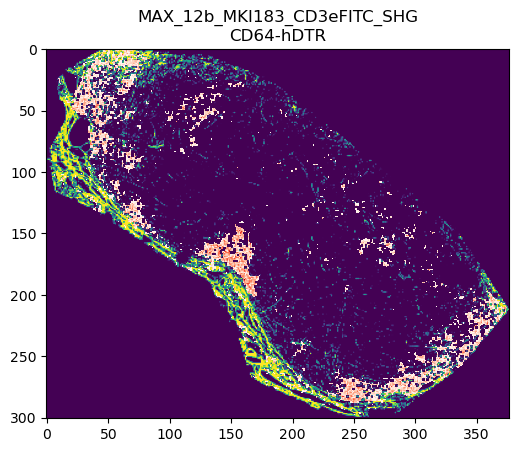

In [61]:
# View cell with density
i = 14
name = dt_byfile.index[i]
m = ExtractMap.ExtractMap(df_all_cd3_intumor, "Density20", choose=name)
plt.imshow(m)
p = ExtractMap.ExtractMap(df_all_cd3_intumor, "Cells", choose=name)
p[p == 0] = np.nan
plt.imshow(p, cmap=plt.cm.Reds)
plt.title(f"{dt_byfile['Name'].iloc[i]}\n{dt_byfile['Condition'].iloc[i]}")
plt.show()

In [93]:
plt.get_fignums()

[]

In [ ]:

fig = plt.figure(figsize=(10, 8))
sns.barplot(data=dt_byfile, x="Name", y="count", hue="Condition")
plt.title(
    "Jeu de données CD3\n"
    "Nombre d'observations au sein de la tumeur\n"
    "des tissus WT/CD64-hDTR"
)
plt.xticks(rotation=90)
plt.ylabel("Nombre d'observations")
#plt.show()

for idx, name in enumerate(dt_byfile.index):
    fig = plt.figure(figsize=(10, 8))
    m = ExtractMap.ExtractMap(df_all_cd3[df_all_cd3["Mask"] == 1], "Density20", choose=name)
    plt.imshow(m)
    p = ExtractMap.ExtractMap(df_all_cd3[df_all_cd3["Mask"] == 1], "Cells", choose=name)
    p[p == 0] = np.nan
    plt.imshow(p, cmap=plt.cm.Reds)
    plt.title(
        f"{dt_byfile['Name'].iloc[idx]}\n"
        f"{dt_byfile['Condition'].iloc[idx]}\n"
        f"Nombre d'observations : {dt_byfile['count'].iloc[idx]}"
    )

plt.get_fignums()   
    figs = [plt.figure(n) for n in fig_nums]
save_image("test")
plt.close()

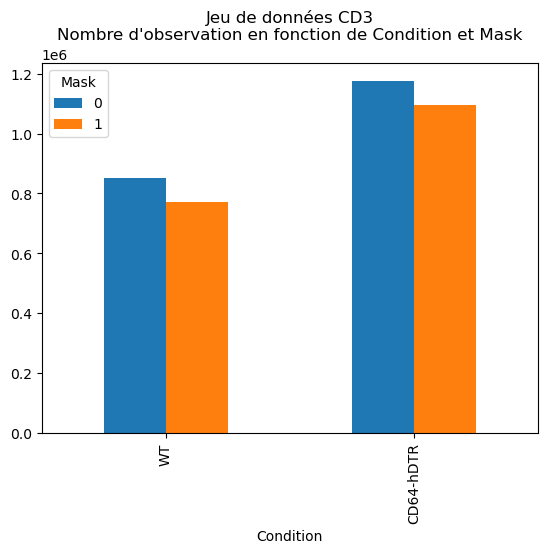

Mask             0        1
Condition                  
WT          851811   770766
CD64-hDTR  1176690  1097098


In [27]:
# 
table_cond_mask.plot(kind="bar")
plt.title(
    "Jeu de données CD3\n"
    "Nombre d'observation en fonction de Condition et Mask"
)
plt.show()
print(table_cond_mask)

/home/etudiant/.conda/envs/BI/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/etudiant/.conda/envs/BI/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/etudiant/.conda/envs/BI/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/etudiant/.conda/envs/BI/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isin

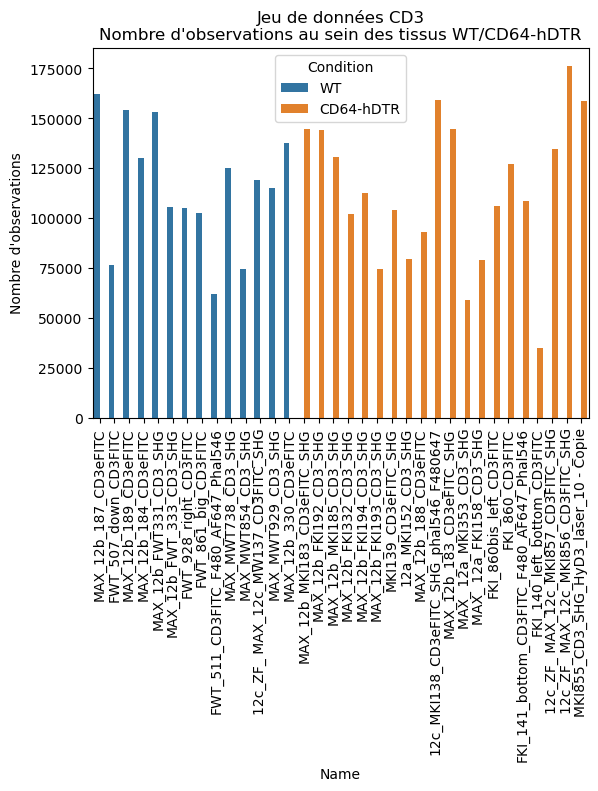

In [11]:
# Nombre d'observations par image
sns.barplot(data=dt_byfile, x="Name", y="count", hue="Condition")
plt.title(
    "Jeu de données CD3\n"
    "Nombre d'observations au sein des tissus WT/CD64-hDTR"
)
plt.xticks(rotation=90)
plt.ylabel("Nombre d'observations")
plt.show()

/home/etudiant/.conda/envs/BI/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/etudiant/.conda/envs/BI/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/etudiant/.conda/envs/BI/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/etudiant/.conda/envs/BI/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isin

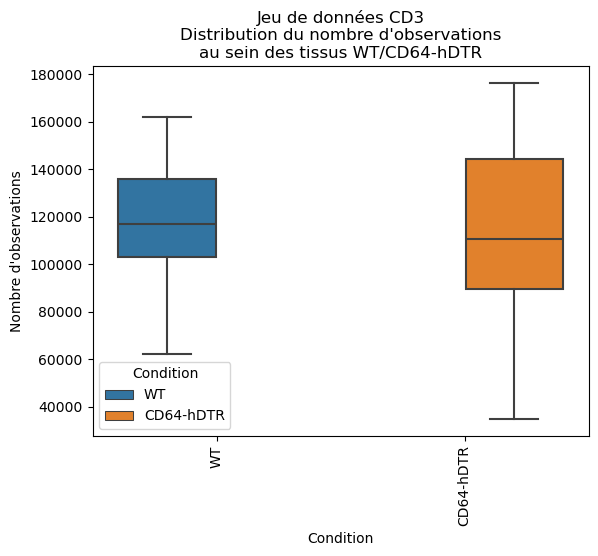

In [12]:
# Distribution du nombre d'observations par image
sns.boxplot(data=dt_byfile, x="Condition", y="count", hue="Condition")
plt.title("Jeu de données CD3\n"
          "Distribution du nombre d'observations\n"
          "au sein des tissus WT/CD64-hDTR")
plt.xticks(rotation=90)
plt.ylabel("Nombre d'observations")
plt.show()

In [13]:
# Statistics
stats.ttest_ind(
    dt_byfile[dt_byfile["Condition"] == "WT"]["count"],
    dt_byfile[dt_byfile["Condition"] == "CD64-hDTR"]["count"],
    equal_var = False
)  # No differences between number of value distribution in the two condition

TtestResult(statistic=0.19013370919743838, pvalue=0.8504487125901021, df=30.880958038289354)

## Comparaison des distribution entre WT et CD64-hDTR

On s'intéresse ici à la distribution des différents descripteurs selon la Condition étudiée, ici si le tissu est de phénotype WT (avec macrophage) et lorsque le tissu est de phénotype CD64-hDTR (déplété en macrophage).

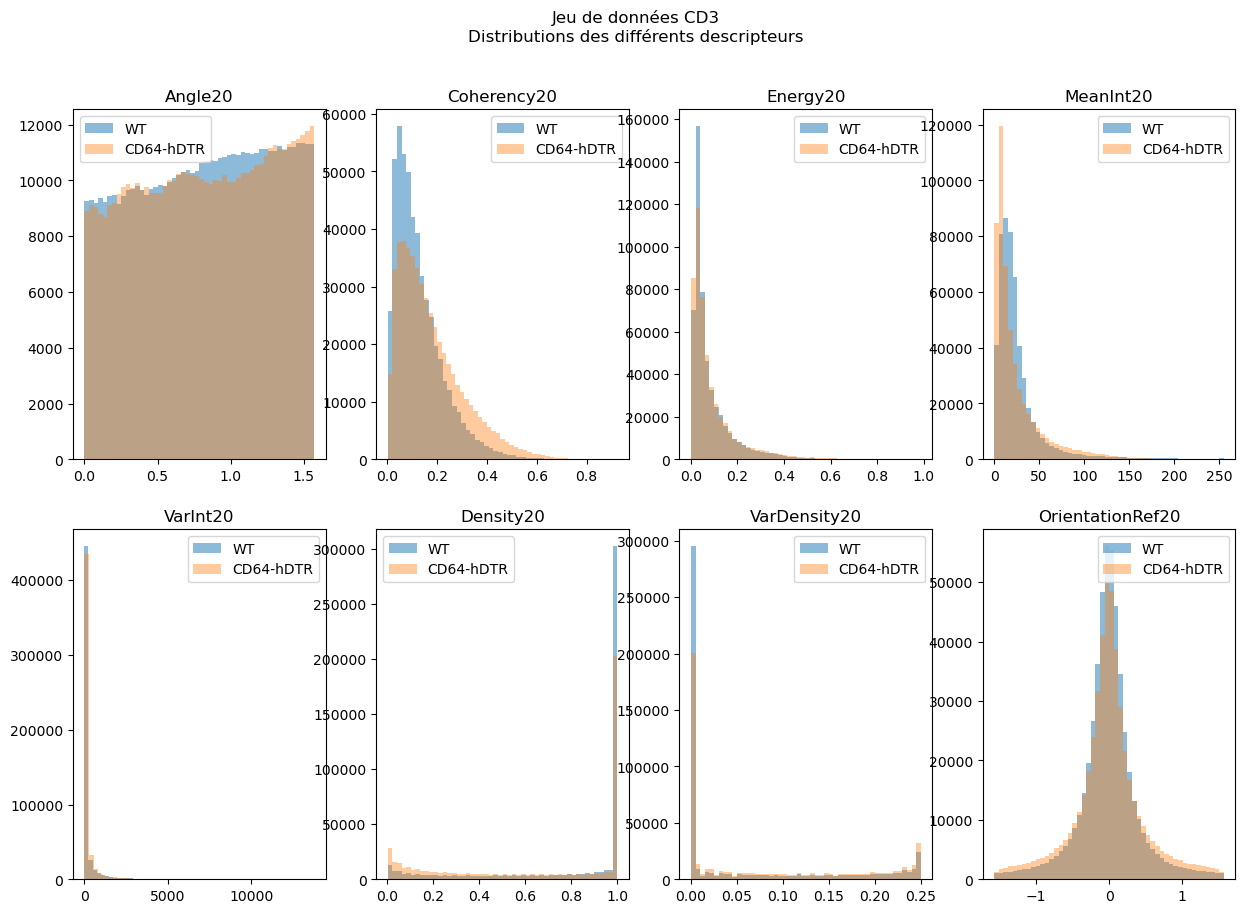

In [21]:
pixel_size = 20
descriptors = ["Angle", "Coherency", "Energy", "MeanInt", "VarInt", "Density", "VarDensity", "OrientationRef"]
descriptors = [i+str(pixel_size) for i in descriptors]
fig, ax = plt.subplots(2, i2:=4, figsize=(15, 10))
fig.suptitle("Jeu de données CD3\n"
             "Distributions des différents descripteurs")

df_tmp = df_all_cd3[df_all_cd3["Density20"] > 0]
for i, des in enumerate(descriptors):
    idx0, idx1 = i//i2, i%i2
    actual_axis = ax[idx0][idx1]
    actual_axis.hist(df_tmp[df_tmp["Condition"] == "WT"][des], label="WT", bins=50, alpha=0.5)
    actual_axis.hist(df_tmp[df_tmp["Condition"] == "CD64-hDTR"][des], label="CD64-hDTR", bins=50, alpha=0.4)
    actual_axis.set_title(des)
    actual_axis.legend()
plt.show()

In [ ]:
fig, ax = plt.subplots(2, 4, figsize=(15, 10))
fig.suptitle("Jeu de données CD3\n"
             "Distributions des différents descripteurs")

for i, des in enumerate(descriptors):
    idx0, idx1 = i//4, i%4
    actual_axis = ax[idx0][idx1]
    actual_axis.boxplot([df_tmp[df_tmp["Condition"] == "WT"][des], df_tmp[df_tmp["Condition"] == "CD64-hDTR"][des]])
    actual_axis.set_title(des)
    actual_axis.legend()
plt.show()

In [ ]:
plots.dual_plot(
    df_all_cd3.index,
    df_all_cd3[df_all_cd3["Condition"] == "WT"]["OrientationRef20"],
    df_all_cd3[df_all_cd3["Condition"] == "CD64-hDTR"]["OrientationRef20"]
)
plt.show()

In [ ]:
plt.hist(df_all_cd3["Cells100um"], bins=100)m
plt.show()

In [ ]:
df_all_cd3["Cells100um"].mean()